In [1]:
import numpy as np

In [2]:
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

/Users/piero/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


170500096/170498071 [==============================] - 122s 1us/step


In [24]:
import cv2

print(x_train.shape)
print(x_test.shape)

x_train_resized = np.array([cv2.resize(sample, dsize=(48, 48), interpolation=cv2.INTER_CUBIC) for sample in x_train])
x_test_resized = np.array([cv2.resize(sample, dsize=(48, 48), interpolation=cv2.INTER_CUBIC) for sample in x_test])

print(x_train_resized.shape)
print(x_test_resized.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 48, 48, 3)
(10000, 48, 48, 3)


In [51]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

model = applications.VGG19(weights = "imagenet", include_top=False, input_shape=x_train_resized[0].shape)

print('layers in pre-trained model: {}'.format(len(model.layers)))

# Freeze the layers which you don't want to train. Here I am freezing the first 5 layers.
for layer in model.layers:
    layer.trainable = False
    
model.summary()

nb_classes = len(np.unique(y_train))
    
# Adding custom Layers 
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
output_layer = Dense(nb_classes, activation="softmax")(x)

# creating the final model 
model_final = Model(input=model.input, output=output_layer)

# compile the model 
model_final.compile(
    loss="categorical_crossentropy", 
    optimizer=optimizers.SGD(lr=0.0001, momentum=0.9), 
    metrics=["accuracy"]
)

layers in pre-trained model: 22
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 

/Users/piero/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [52]:
# Initiate the train and test generators with data Augumentation 
#train_datagen = ImageDataGenerator(
#rescale = 1./255,
#horizontal_flip = True,
#fill_mode = "nearest",
#zoom_range = 0.3,
##width_shift_range = 0.3,
#height_shift_range=0.3,
#rotation_range=30)

#test_datagen = ImageDataGenerator(
#rescale = 1./255,
#horizontal_flip = True,
#fill_mode = "nearest",
#zoom_range = 0.3,
#width_shift_range = 0.3,
#height_shift_range=0.3,
#rotation_range=30)

#train_generator = train_datagen.flow_from_directory(
#train_data_dir,
#target_size = (img_height, img_width),
#batch_size = batch_size, 
#class_mode = "categorical")

#validation_generator = test_datagen.flow_from_directory(
#validation_data_dir,
#target_size = (img_height, img_width),
#class_mode = "categorical")

# Save the model according to the conditions  
checkpoint = ModelCheckpoint("cifar10_vgg19.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0.000001, patience=3, verbose=1, mode='auto')
nb_train_samples = int(len(x_train) * 0.85)

y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

x_val = x_train_resized[nb_train_samples:]
y_val = y_train_categorical[nb_train_samples:]

# Train the model 
history = model_final.fit(
    x_train_resized[:nb_train_samples],
    y_train_categorical[:nb_train_samples],
    validation_data=(x_val, y_val),
    batch_size=16,
    epochs=10,
    callbacks=[checkpoint, early]
)

Train on 42500 samples, validate on 7500 samples
Epoch 1/10
42500/42500 [==============================] - 1260s 30ms/step - loss: 2.8522 - acc: 0.4453 - val_loss: 1.2614 - val_acc: 0.5709

Epoch 00001: val_acc improved from -inf to 0.57093, saving model to cifar10_vgg19.h5
Epoch 2/10
42500/42500 [==============================] - 1256s 30ms/step - loss: 1.4915 - acc: 0.5217 - val_loss: 1.1804 - val_acc: 0.5959

Epoch 00002: val_acc improved from 0.57093 to 0.59587, saving model to cifar10_vgg19.h5
Epoch 3/10
42500/42500 [==============================] - 1206s 28ms/step - loss: 1.3132 - acc: 0.5596 - val_loss: 1.1442 - val_acc: 0.6071

Epoch 00003: val_acc improved from 0.59587 to 0.60707, saving model to cifar10_vgg19.h5
Epoch 4/10
42500/42500 [==============================] - 1194s 28ms/step - loss: 1.2244 - acc: 0.5843 - val_loss: 1.1244 - val_acc: 0.6101

Epoch 00004: val_acc improved from 0.60707 to 0.61013, saving model to cifar10_vgg19.h5
Epoch 5/10
42500/42500 [==============

In [53]:
model_final.evaluate(x_test_resized, y_test_categorical)

10000/10000 [==============================] - 227s 23ms/step


[1.0566693477630615, 0.6413]

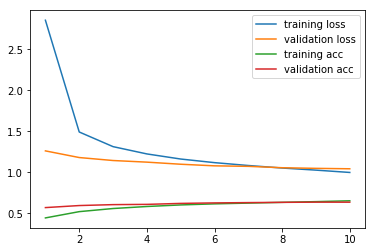

In [62]:
import matplotlib.pyplot as plt

history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
acc = history_dict['acc']
val_acc = history_dict['val_acc']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, label='training loss')
plt.plot(epochs, val_loss, label='validation loss')
plt.plot(epochs, acc, label='training acc')
plt.plot(epochs, val_acc, label='validation acc')
plt.legend()
plt.show()

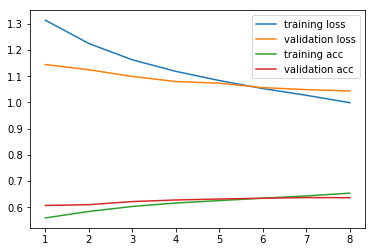

In [64]:
# remove first epochs to show fine-grained measures
keep_from = 2
loss, val_loss, acc, val_acc = history_dict['loss'][keep_from:], history_dict['val_loss'][keep_from:], history_dict['acc'][keep_from:], history_dict['val_acc'][keep_from:]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, label='training loss')
plt.plot(epochs, val_loss, label='validation loss')
plt.plot(epochs, acc, label='training acc')
plt.plot(epochs, val_acc, label='validation acc')
plt.legend()
plt.show()

In [65]:
x_train.shape

(50000, 32, 32, 3)